In [1]:
try:
    #!rm foolsunet_imagenette.weights.h5
    passes += 1
    #!git stash
    !git pull --force
except:
    passes = 1
    !git clone https://github.com/arminwitte/FoolsUNet.git
    %cd FoolsUNet
    !git pull --force

Cloning into 'FoolsUNet'...
remote: Enumerating objects: 513, done.
remote: Counting objects: 100% (358/358), done.
remote: Compressing objects: 100% (219/219), done.
remote: Total 513 (delta 222), reused 213 (delta 139), pack-reused 155 (from 1)
Receiving objects: 100% (513/513), 110.73 MiB | 24.90 MiB/s, done.
Resolving deltas: 100% (303/303), done.
Updating files: 100% (41/41), done.
/kaggle/working/FoolsUNet
Already up to date.


In [2]:
import tensorflow as tf

print(tf.__version__)

2024-09-27 12:57:11.347465: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-27 12:57:11.347591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-27 12:57:11.484845: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0


In [3]:
#resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
#tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
#tf.tpu.experimental.initialize_tpu_system(resolver)
#print("All devices: ", tf.config.list_logical_devices('TPU'))

In [4]:
import tensorflow_datasets as tfds

In [5]:
dataset, info = tfds.load("imagenette/320px-v2:1.*.*", with_info=True, data_dir="./data/")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/9469 [00:00<?, ? examples/s]

Shuffling data/imagenette/320px-v2/1.0.0.incompleteO3ZM8L/imagenette-train.tfrecord*...:   0%|          | 0/94…

Generating validation examples...:   0%|          | 0/3925 [00:00<?, ? examples/s]

Shuffling data/imagenette/320px-v2/1.0.0.incompleteO3ZM8L/imagenette-validation.tfrecord*...:   0%|          |…

Dataset imagenette downloaded and prepared to ./data/imagenette/320px-v2/1.0.0. Subsequent calls will reuse this data.


In [6]:
dataset

{Split('train'): <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 Split('validation'): <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [7]:
def normalize(input_image):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image

In [8]:
def load_image(datapoint):
    input_image = tf.image.resize(datapoint["image"], (256, 256))
    input_label = datapoint["label"]

    input_image = normalize(input_image)

    return input_image, input_label

In [9]:
TRAIN_LENGTH = info.splits["train"].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = TRAIN_LENGTH
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
print(f"train length: {TRAIN_LENGTH}")
print(f"train length: {TRAIN_LENGTH / BATCH_SIZE}")
print(f"train length: {STEPS_PER_EPOCH}")

train length: 9469
train length: 147.953125
train length: 147


In [10]:
train_images = dataset["train"].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset["validation"].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [11]:
from tensorflow.keras import layers
class Augment(layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = layers.RandomFlip(mode="horizontal", seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        return inputs, labels

In [12]:
train_batches = (
    train_images.cache()
    .shuffle(BUFFER_SIZE)
    .repeat()
    .batch(BATCH_SIZE, drop_remainder=True)
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_batches = test_images.batch(BATCH_SIZE)

## Get pre-trained encoder and attach classification head

In [13]:
from foolsunet.model import foolsunet, encoder, classification_head

In [14]:
num_classes = 10

In [15]:
strategy = tf.distribute.MirroredStrategy()
#strategy = tf.distribute.TPUStrategy(resolver)
with strategy.scope():
    # base_model_1 = tf.keras.models.load_model("foolsunet_imagenet_resized_6-9_epoch.keras")
    # base_model_2 = foolsunet(channel_attention="eca")
    # base_model_1.summary()
    enc = encoder()
    print(enc.output_shape)
    head = classification_head(num_classes, input_shape=enc.output_shape[1:])
    

(None, 16, 16, 54)


In [16]:
def assemble_model():
    model = tf.keras.Sequential([enc,head])
    model.build()
    return model 

### Define encoder

# Use the activations of these layers
layer_names = [
    'block_1_downsample',   # 64x64
    #'block_2_downsample',   # 32x32
]
base_model_layers = [base_model_2.get_layer(name) for name in layer_names]
layer_names = [
    'block_2_invres_downsample',   # 32x32
    'block_3_invres_downsample',   # 16x16
    # 'block_4_invres_downsample',  # 8x8
    # 'block_5_invres_downsample',      # 4x4
    # 'block_6_invres_downsample'
]
base_model_layers += [base_model_2.get_layer(name) for name in layer_names]

# # Create the feature extraction model
# down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

# down_stack.trainable = False

### Define classifier

def assemble_model():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    x = inputs
#     x = base_model.input
#     x = down_stack(inputs)
    for layer in base_model_layers:
#         layer.trainable = False
        x = layer(x)
    x = tf.keras.layers.Conv2D(1024, 1)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Activation("relu6")(x)
    x = tf.keras.layers.Conv2D(num_classes, 1)(x)
    x = tf.keras.layers.GlobalAveragePooling2D(name="outputs")(x)

    
    return tf.keras.Model(inputs=inputs, outputs=x)

def assemble_model():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    x = inputs
#     x = base_model.input
#     x = down_stack(inputs)
    for layer in base_model_layers:
#         layer.trainable = False
        x = layer(x)
    x = tf.keras.layers.Conv2D(1024, 1)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Activation("relu6")(x)
    x = tf.keras.layers.AveragePooling2D(32)(x)
    x = tf.keras.layers.Conv2D(num_classes, 1)(x)
    x = tf.keras.layers.Flatten(name="outputs")(x)

    
    return tf.keras.Model(inputs=inputs, outputs=x)

In [17]:
# classification_head = tf.keras.Sequential([
#     tf.keras.layers.Input([8,8,128]),
#     tf.keras.layers.Flatten(),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dense(num_classes, name="outputs"),])
# # classification_head.build()

In [18]:
# model = tf.keras.Sequential([base_model.get_layer(name) for name in layer_names] + [layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes, name="outputs"),
#                                                                                    ])
# model.build()

In [19]:
with strategy.scope():
    model = assemble_model()
    opt = tf.keras.optimizers.Adam(learning_rate=0.005)
    model.compile(
    optimizer=opt,
    #Anything between 2 and `steps_per_epoch` could help here.
    #steps_per_execution = 50,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
    model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_1 (Functional)       │ ?                      │       160,074 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_3 (Functional)       │ ?                      │       656,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 816,884 (3.12 MB)

 Trainable params: 814,364 (3.11 MB)

 Non-trainable params: 2,520 (9.84 KB)

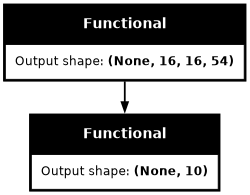

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [21]:
EPOCHS = 20
VAL_SUBSPLITS = 1
VALIDATION_STEPS = info.splits["validation"].num_examples // BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(
    train_batches,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_batches,
    # callbacks=[DisplayCallback()]
    # callbacks=[tf.keras.callbacks.EarlyStopping(restore_best_weights=True, start_from_epoch=10)],
)

Epoch 1/20


2024-09-27 12:58:49.312970: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/functional_1_1/block_1_conv_0_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


147/147 ━━━━━━━━━━━━━━━━━━━━ 152s 798ms/step - accuracy: 0.2233 - loss: 2.3915 - val_accuracy: 0.2382 - val_loss: 2.3067
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 106s 723ms/step - accuracy: 0.3684 - loss: 1.8143 - val_accuracy: 0.1905 - val_loss: 5.3662
Epoch 3/20


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


147/147 ━━━━━━━━━━━━━━━━━━━━ 115s 782ms/step - accuracy: 0.4568 - loss: 1.5678 - val_accuracy: 0.2938 - val_loss: 3.1792
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 104s 709ms/step - accuracy: 0.5330 - loss: 1.3824 - val_accuracy: 0.1429 - val_loss: 6.3989
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 115s 782ms/step - accuracy: 0.5730 - loss: 1.2487 - val_accuracy: 0.2690 - val_loss: 3.4082
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 104s 709ms/step - accuracy: 0.6166 - loss: 1.1389 - val_accuracy: 0.7143 - val_loss: 1.0231
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 115s 782ms/step - accuracy: 0.6445 - loss: 1.0410 - val_accuracy: 0.5095 - val_loss: 1.9297
Epoch 8/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 104s 709ms/step - accuracy: 0.6824 - loss: 0.9503 - val_accuracy: 0.3810 - val_loss: 3.0585
Epoch 9/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 115s 782ms/step - accuracy: 0.6921 - loss: 0.9259 - val_accuracy: 0.5594 - val_loss: 1.4372
Epoch 10/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 104s 709ms/step - accuracy: 0.7126 - loss: 0.8

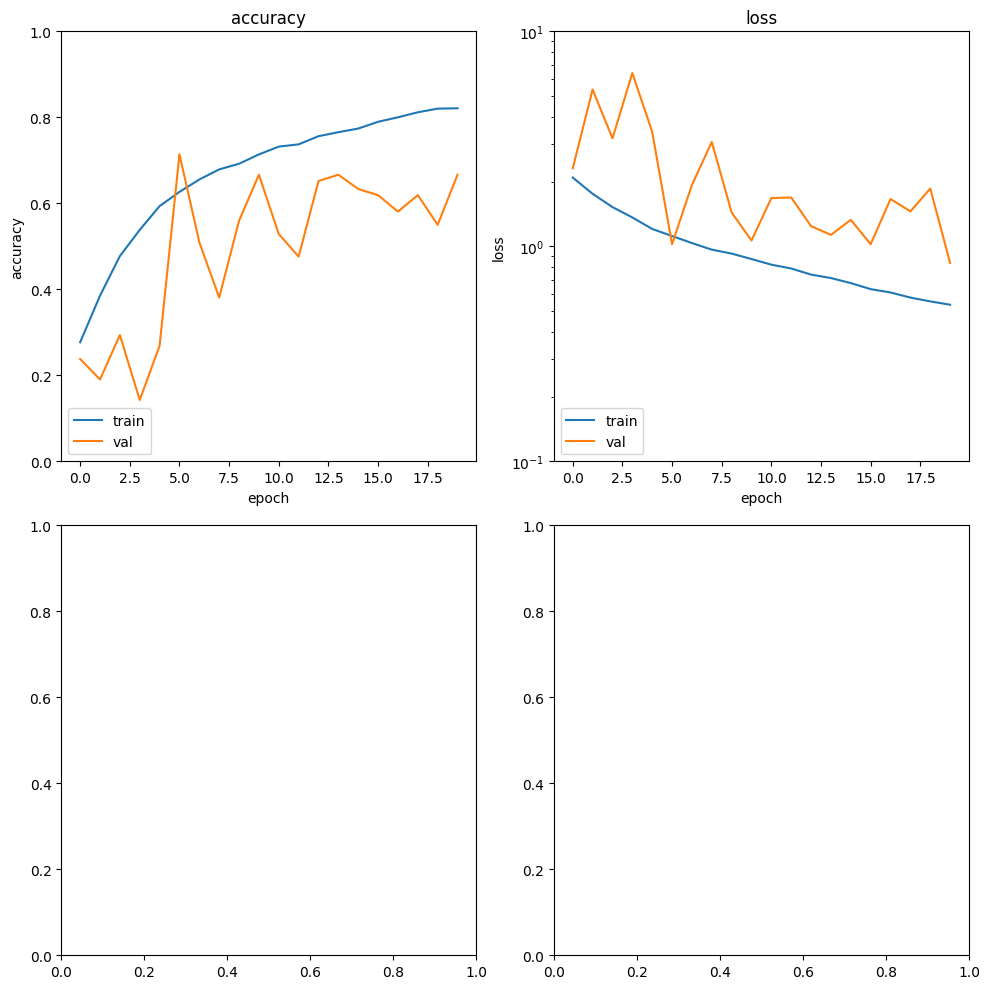

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].plot(model_history.history["accuracy"])
ax[0, 0].plot(model_history.history["val_accuracy"])
ax[0, 0].set_title("accuracy")
ax[0, 0].set_ylabel("accuracy")
ax[0, 0].set_xlabel("epoch")
ax[0, 0].set_ylim(0.0,1.0)
ax[0, 0].legend(["train", "val"], loc="lower left")


ax[0, 1].plot(model_history.history["loss"])
ax[0, 1].plot(model_history.history["val_loss"])
ax[0, 1].set_yscale("log")
ax[0, 1].set_title("loss")
ax[0, 1].set_ylabel("loss")
ax[0, 1].set_xlabel("epoch")
ax[0, 1].set_ylim(0.1,10.0)
ax[0, 1].legend(["train", "val"], loc="lower left")

# ax[1, 0].plot(model_history.history["regression_output_weighted_mse"])
# ax[1, 0].plot(model_history.history["val_regression_output_weighted_mse"])
# ax[1, 0].set_yscale("log")
# ax[1, 0].set_title("val_regression_output_weighted_mse")
# ax[1, 0].set_ylabel("accuracy")
# ax[1, 0].set_xlabel("epoch")
# ax[1, 0].legend(["train", "val"], loc="lower left")

fig.tight_layout()

In [23]:
# Save the entire model as a `.keras` zip archive.
model.save("foolsunet_imagenette.keras")

In [24]:

model.save_weights("foolsunet_imagenette.weights.h5")

In [25]:
new_model = tf.keras.models.load_model("foolsunet_imagenette.keras")

# Show the model architecture
new_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_1 (Functional)       │ ?                      │       160,074 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_3 (Functional)       │ ?                      │       656,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,445,614 (9.33 MB)

 Trainable params: 814,364 (3.11 MB)

 Non-trainable params: 2,520 (9.84 KB)

 Optimizer params: 1,628,730 (6.21 MB)